# 📊 **Data Visualisation**

In this notebook, I read data directly from my SQLite database into Pandas DataFrames. I then conducted Exploratory Data Analysis and created visualisations focused on the question of the "TikTokiness" of Spotify.

**Key content**:
* Conducted **EDA** to visualise data
* Created a **`TikTok_Score`**, based on weights of how different features met the criteria for "TikTokability"
* Used **a variety of data visualisations**, including Heatmaps, Scatter Plots, Linear Regressions and [DBSCAN Clustering](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.DBSCAN.html)

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN
from plotnine import *
import ipywidgets as widgets
from IPython.display import display

In [36]:
# Run this cell when new functions have been added to my_functions_03.py
import importlib
import my_functions_03

importlib.reload(my_functions_03)

<module 'my_functions_03' from '/Users/shl/Documents/lse/ds105/w10-summative-so-hl/code/my_functions_03.py'>

## **01 Connect to SQLite database**

In [3]:
# Connect to SQLite database
conn = sqlite3.connect("../data/processed/spotify.db")

# Load each table
tracks_df = pd.read_sql_query("SELECT * FROM Tracks", conn)
features_df = pd.read_sql_query("SELECT * FROM Features", conn)
track_to_playlist_df = pd.read_sql_query("SELECT * FROM Track_To_Playlist", conn)

# Close the connection
conn.close()

In [4]:
# Merge Tracks and Features dataframes
data_df = pd.merge(tracks_df, features_df, on="Track_ID", how="left")

In [5]:
data_df

,Track_Name,Track_ID,Popularity,Region,Energy,Tempo,Danceability,Mode,Acousticness
0,squabble up,0nj9Bq5sHDiTxSHunhgkFb,86,USA,0.672,103.921,0.874,1,0.021
1,tv off (feat. lefty gunplay),0aB0v4027ukVziUGwVGYpG,85,USA,0.529,100.036,0.855,0,0.084
2,luther (with sza),2CGNAOSuO1MEFCbBRgUzjd,64,USA,0.575,138.008,0.707,1,0.251
3,wacced out murals,5gOfC9UzZQzTyShqPMrpjT,84,USA,0.501,81.998,0.761,0,0.249
4,hey now (feat. dody6),5S8VwnB4sLi6W0lYTWYylu,83,USA,0.358,102.011,0.806,1,0.004
...,...,...,...,...,...,...,...,...,...
480,The Emptiness Machine,2PnlsTsOTLE5jnBnNe2K0A,89,UK,0.872,184.115,0.466,1,0.016
481,Training Season,6Qb7YsAqH4wWFUMbGsCpap,74,UK,0.587,123.041,0.812,0,0.035
482,Who,7tI8dRuH2Yc6RuoTjxo4dU,92,UK,0.756,116.034,0.660,0,0.003
483,BAND4BAND (feat. Lil Baby),7iabz12vAuVQYyekFIWJxD,81,UK,0.764,140.113,0.882,1,0.359


## 🤔 **How "TikTok-like" are today's top hits?**

## **02 Exploratory Data Analysis**

### **01 Summary statistics of each feature**

In [6]:
data_df["Energy"].describe()

count    485.000000
mean       0.620629
std        0.183813
min        0.076000
25%        0.500000
50%        0.643000
75%        0.757000
max        0.986000
Name: Energy, dtype: float64

In [7]:
data_df["Tempo"].describe()

count    485.000000
mean     123.408596
std       28.200835
min       66.495000
25%      103.921000
50%      119.972000
75%      143.994000
max      194.055000
Name: Tempo, dtype: float64

In [8]:
data_df["Danceability"].describe()

count    485.000000
mean       0.633887
std        0.159392
min        0.233000
25%        0.509000
50%        0.645000
75%        0.750000
max        0.936000
Name: Danceability, dtype: float64

In [9]:
data_df["Mode"].describe()

count    485.000000
mean       0.678351
std        0.467592
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Mode, dtype: float64

In [10]:
data_df["Acousticness"].describe()

count    485.000000
mean       0.263443
std        0.276833
min        0.000000
25%        0.039000
50%        0.146000
75%        0.475000
max        0.968000
Name: Acousticness, dtype: float64

### **02 Summary statistics of popularity**

### Distribution of Popularity
using a *Histogram*

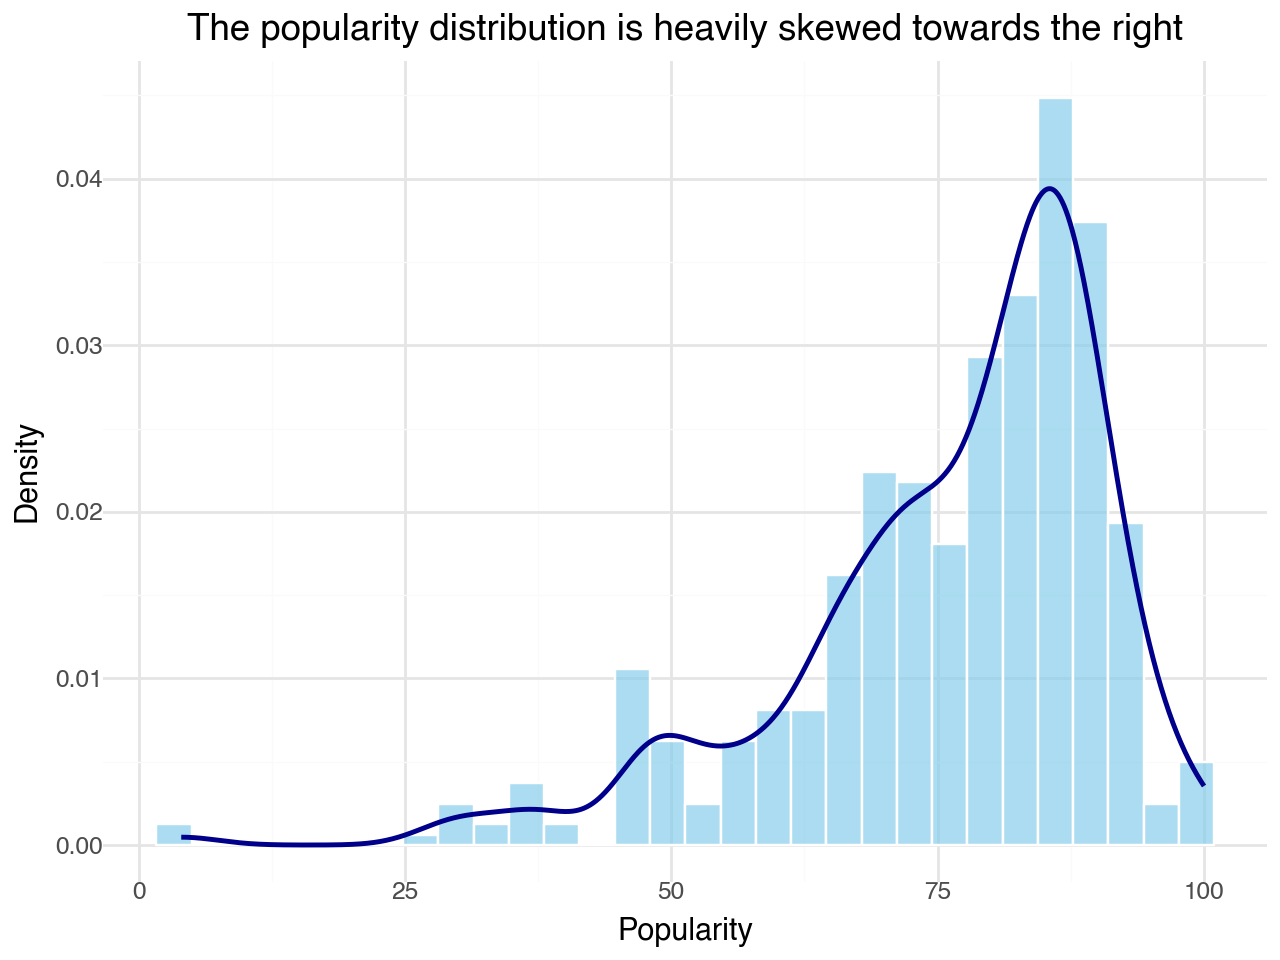

In [11]:
plot = (
    ggplot(data_df, aes(x="Popularity"))
    + geom_histogram(aes(y="..density.."), bins=30, fill="skyblue", color="white", alpha=0.7)  # Histogram
    + geom_density(color="darkblue", size=1)  # Density line
    + labs(title="The popularity distribution is heavily skewed towards the right", x="Popularity", y="Density")
    + theme_minimal()
)

display(plot)

### **Correlation Matrix of Features**
using a *Heatmap*

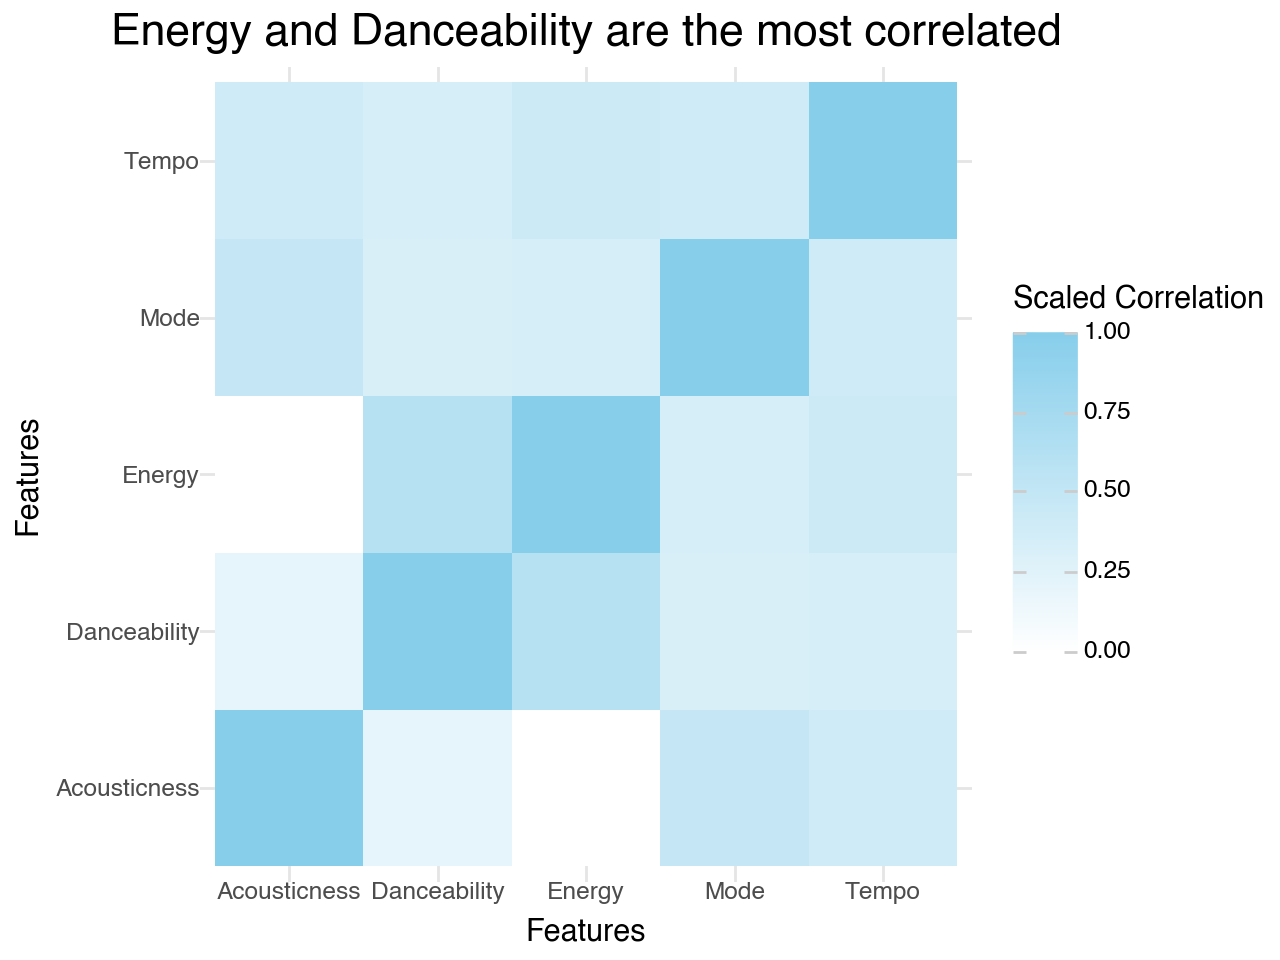

In [12]:
# Correlation Visualisation
features_only_df = features_df.drop(columns=["Track_ID"])
correlation_matrix = features_only_df.corr().reset_index().melt(id_vars="index")
scaler = MinMaxScaler()
correlation_matrix["Scaled_Correlation"] = scaler.fit_transform(correlation_matrix[["value"]])


plot = (
    ggplot(correlation_matrix, aes(x="index", y="variable", fill="Scaled_Correlation"))
    + geom_tile()  # Create tiles for the heatmap effect
    + scale_fill_gradient2(
        low="red", high="skyblue", mid="white", midpoint=0, name="Scaled Correlation"  # Color scale for correlation
    )
    + theme_minimal()
    + labs(
        title="Energy and Danceability are the most correlated",
        x="Features",
        y="Features"
    ) + 
    theme(
        plot_title=element_text(weight="bold", size=16)
    )
)

display(plot)

#### **ANALYSIS: Features**    
1. **Negligible** correlation  
* Energy + Acousticness 
* Danceability + Acousticness

2. **Moderate** correlation  
* Tempo + Danceability
* Tempo + Energy
* Tempo + Mode
* Mode + Danceability
* Mode + Energy
* Tempo + Acousticness

3. **Strong** correlation  
* Mode + Acousticness
* Energy + Danceability

### **Relationship between individual Features and Popularity**
using an interactive *Scatter Plot* with a *Regression Line*

In [13]:
# Define features
features = ["Energy", "Tempo", "Danceability", "Mode", "Acousticness"]

# Create a dropdown for feature selection
dropdown = widgets.Dropdown(
    options=features,
    value="Energy",
    description="Feature:"
)

# Interactive widget display
widgets.interactive(my_functions_03.update_plot_feature, df=widgets.fixed(data_df), feature=dropdown)

interactive(children=(Dropdown(description='Feature:', options=('Energy', 'Tempo', 'Danceability', 'Mode', 'Ac…

#### **ANALYSIS: Correlation between individual features and popularity**
1. **Positive** correlation  
* Energy and Popularity
* Danceability and Popularity

2. **Negligible** correlation  
* Tempo and Popularity
* Mode and Popularity

3. **Negative** correlation  
* Acousticness and Popularity

## **03 Defining "TikTokiness" and Finding a ``TikTok_Score``**

First, let's create a **weighted average** of "TikTokiness".


We have 5 metrics that define "TikTokiness":
* High Energy (>0.5)
* High Tempo (>109 BPM)
* High Danceability (>0.5)
* Major Mode (1)
* Low Acousticness (<0.5)


***Previously***, I converted each feature to a **binary format** for easy calculation, before taking a weighted average.

```python
# Convert continuous values to binary based on threshold
binary_df = pd.DataFrame()

for col, threshold in thresholds.items():
    if col == "Acousticness":
        binary_df[col] = (data_df[col] < threshold).astype(int)
    else:
        binary_df[col] = (data_df[col] > threshold).astype(int)

binary_df["Mode"] = data_df["Mode"]
```

However, that resulted in **discrete values** for `TikTok_Score` and difficulty in plotting meaningful trends.

Hence, we use **normalization to scale feature values relative to their thresholds**. 

For **`Energy`**, **`Tempo`** and **`Danceability`**, the values are **positively correlated** to the `Tiktok_Score` (higher values lead to a higher `TikTok_Score`). Hence,
$$
\text{Normalized Value} = \frac{\text{Feature Value}}{\text{Threshold}}
$$

For **`Acousticness`**, the values are **negatively correlated** to the `TikTok_Score` (lower acousticness leads to a higher `TikTok_Score`). Hence,
$$
\text{Normalized Value} = \frac{\text{Threshold} - \text{Feature Value}}{\text{Threshold}}
$$

**`Mode`** is binary (i.e. categorical) so it does not need normalization. 


In [14]:
# Define thresholds
thresholds = {
    "Energy": 0.5,
    "Tempo": 109,
    "Danceability": 0.5,
    "Acousticness": 0.5
}

# Define weights (based on my personal opinion)
weights = pd.Series({
    "Energy": 0.3,
    "Tempo": 0.25,
    "Danceability": 0.25,
    "Mode": 0.1,
    "Acousticness": 0.1
})

In [15]:
# Normalize features
normalized_df = pd.DataFrame()

for col, threshold in thresholds.items():
    if col == "Acousticness":
        normalized_df[col] = np.clip((threshold - data_df[col])/ threshold, 0, 1)
    else:
        normalized_df[col] = np.clip(data_df[col] / threshold, 0, 1)

# Add Mode to normalized_df
normalized_df["Mode"] = data_df["Mode"]

# Calculate TikTok Score
data_df["TikTok_Score"] = normalized_df[weights.keys()].dot(weights)

### **Distribution of TikTok Score**
using a *Histogram* with a *Density Line*

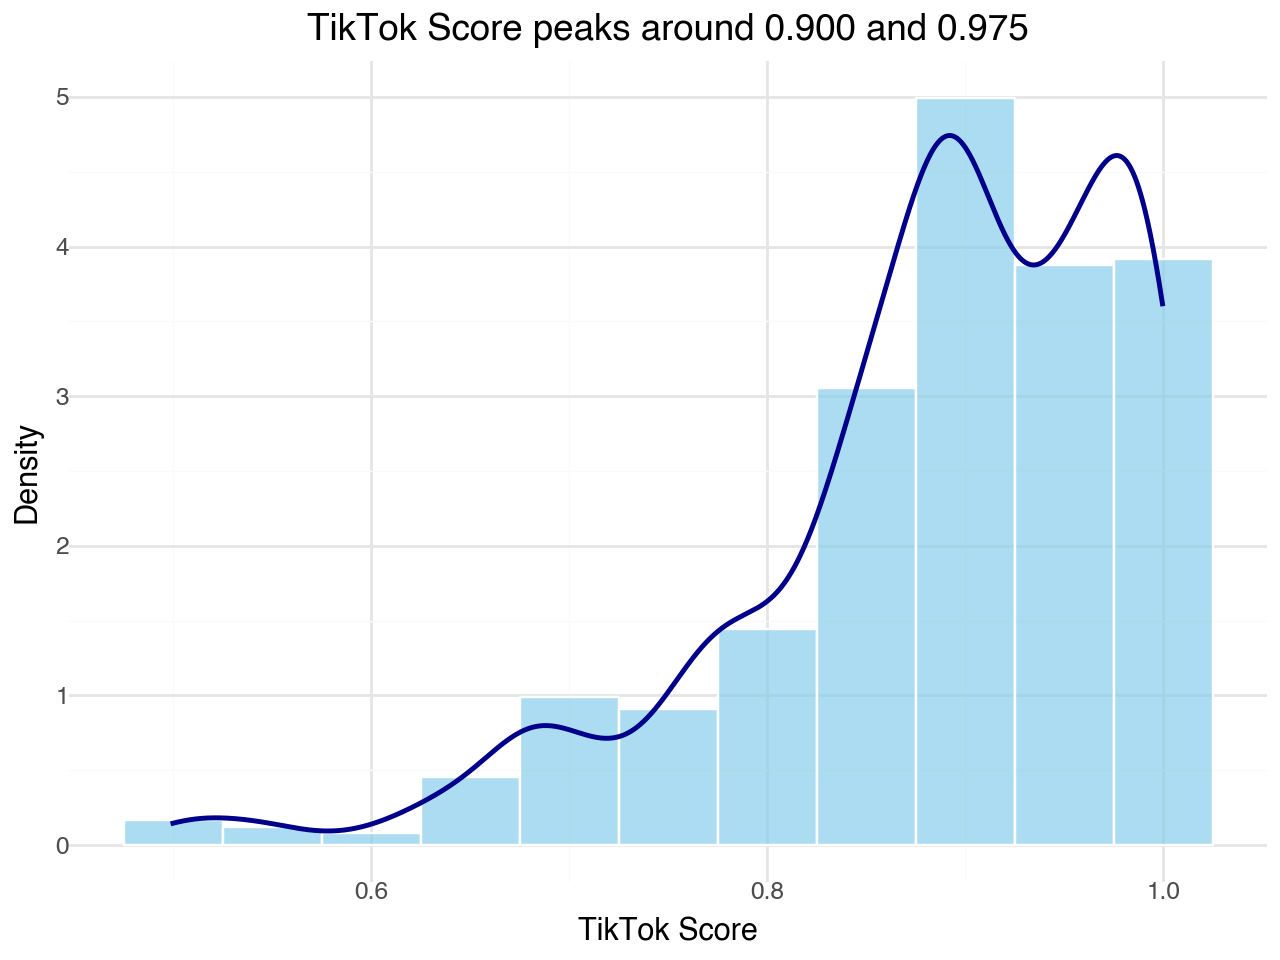

In [16]:
plot = (
    ggplot(data_df, aes(x="TikTok_Score"))
    + geom_histogram(
        aes(y="..density.."), 
        binwidth=0.05, 
        fill="skyblue", 
        color="white", 
        alpha=0.7) # Histogram
    + geom_density(color="darkblue", size=1) # Density line
    + labs(
        title="TikTok Score peaks around 0.900 and 0.975", 
        x="TikTok Score", 
        y="Density"
        )
    + theme_minimal()
)

display(plot)

#### **ANALYSIS**  
The **`TikTok Score`** has a **similar distribution** to the **`Popularity`** distribution - both are significantly skewed towards the right. 

## **04 Data Visualisation**

### **Tiktok Score and Popularity**
using a *Scatter Plot* with a *Regression Line*

#### **NOTE**
Previously, due to the large number of data points that overlapped because of the way `TikTok_Score` was defined, **`geom_jitter()`** was used to add a small random noise to the data points, preventing overplotting. However, now due to the continuous variation of `TikTok_Score`, **`geom_point()`** suffices.

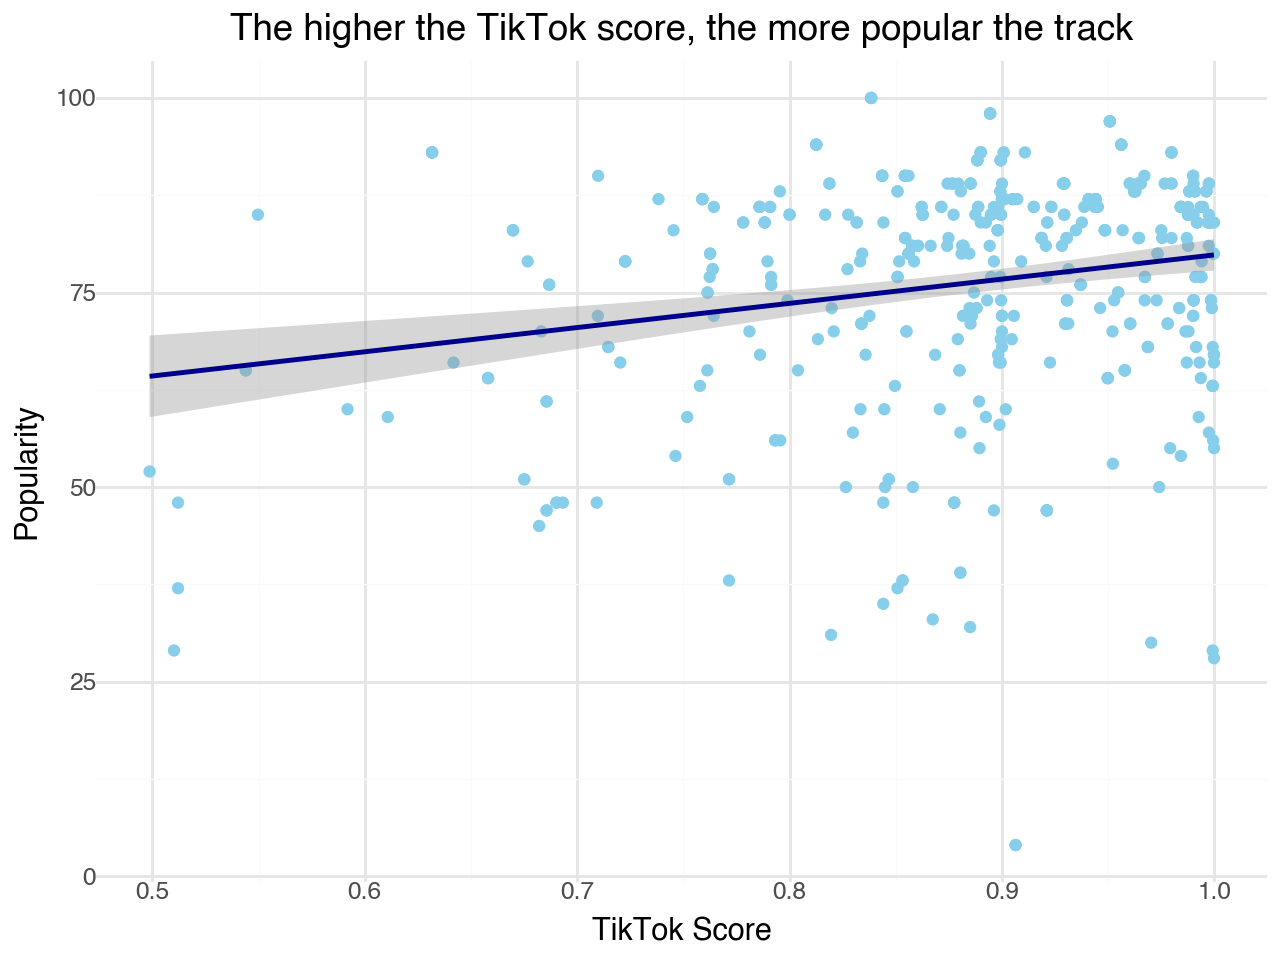

In [17]:
plot = (
    ggplot(data_df, aes(x="TikTok_Score", y="Popularity")) 
    + geom_point(color="skyblue")  # Scatter plot
    + geom_smooth(method="lm", color="darkblue")  # Linear regression line
    + labs(title="The higher the TikTok score, the more popular the track", x="TikTok Score", y="Popularity")
    + theme_minimal()
)

display(plot)


#### **ANALYSIS**  
Overall, the **`TikTok Score`** and **`Popularity`** are generally **positively correlated**. This is further confirmed by calculating the correlation coefficient between the two variables:

In [18]:
correlation = data_df["TikTok_Score"].corr(data_df["Popularity"])
print(correlation)

0.20616824478490817


The correlation coefficient of 0.2062 indicates a **weak positive correlation** between `TikTok_Score` and `Popularity`.

### **TikTok Score vs Popularity by Region**
using *Scatter Plots* with *Regression Lines*

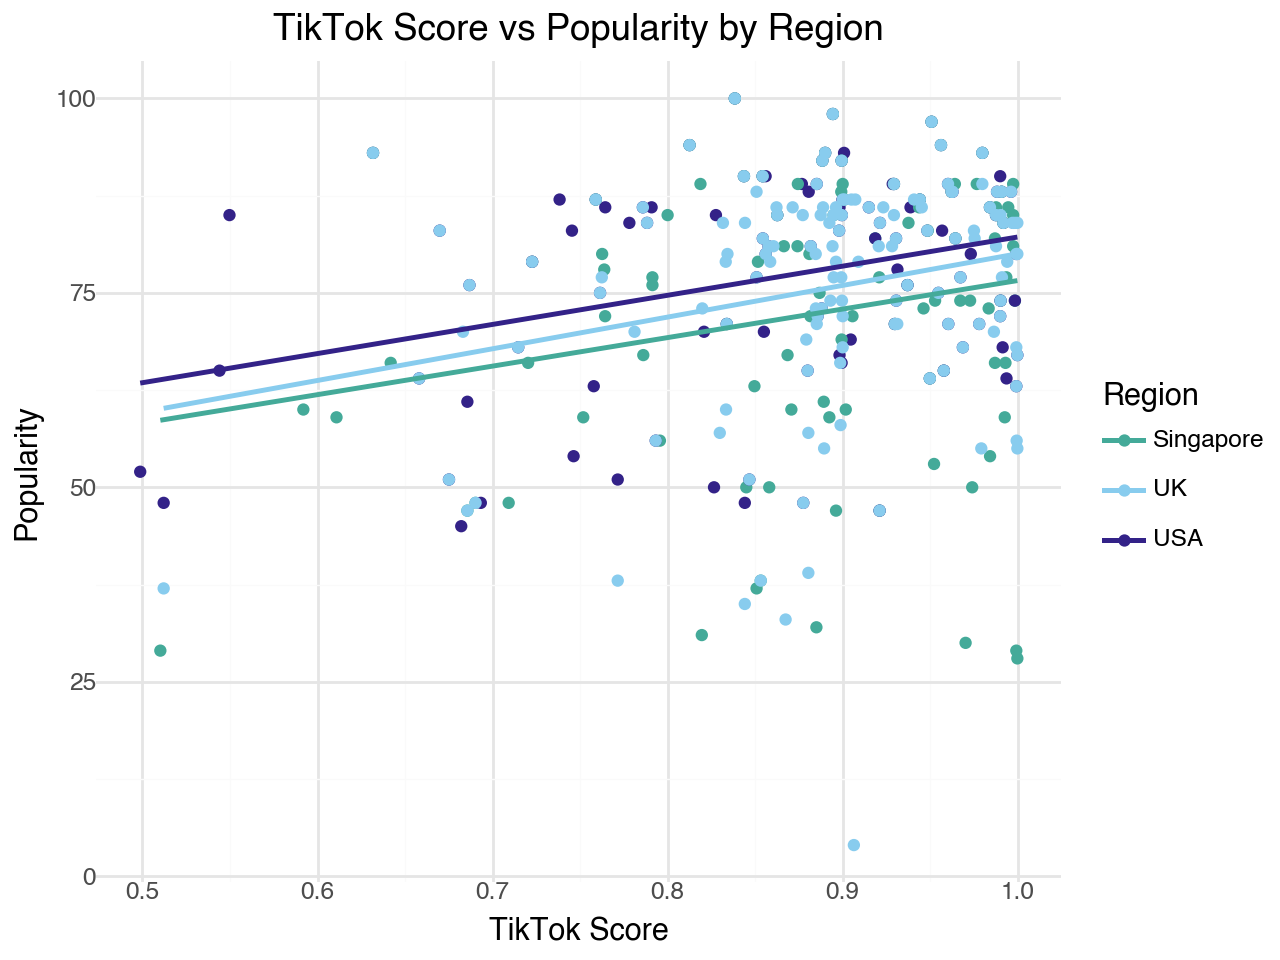

In [19]:
# Filter out the Global region
data_df_filtered = data_df[data_df["Region"] != "Global"]

# Define color palette
palette = {
    "UK": "#88CCEE",
    "USA": "#332288",
    "Singapore": "#44AA99"
}

plot = (
    ggplot(data_df_filtered, aes(x="TikTok_Score", y="Popularity", color="Region")) 
    + geom_point() # Scatter plot
    + geom_smooth(method="lm", se=False) # Linear regression line
    + scale_color_manual(values=palette)
    + labs(
        title="TikTok Score vs Popularity by Region",
        x="TikTok Score",
        y="Popularity"
    )
    + theme_minimal()
)

display(plot)

#### **ANALYSIS**  
The **`TikTok Score`** is positively correlated to **`Popularity`** across regions.
Interestingly, the rate at which `Popularity` increases with `TikTok` score is similar across the 3 regions.

In [20]:
# Calculate correlation for Singapore
singapore_df = data_df[data_df["Region"] == "Singapore"]
singapore_corr = singapore_df["TikTok_Score"].corr(singapore_df["Popularity"])

# Calculate correlation for USA
usa_df = data_df[data_df["Region"] == "USA"]
usa_corr = usa_df["TikTok_Score"].corr(usa_df["Popularity"])

# Calculate correlation for UK
uk_df = data_df[data_df["Region"] == "UK"]
uk_corr = uk_df["TikTok_Score"].corr(uk_df["Popularity"])

# Print the correlation coefficients
print(f"Correlation for Singapore: {singapore_corr}")
print(f"Correlation for USA: {usa_corr}")
print(f"Correlation for UK: {uk_corr}")

Correlation for Singapore: 0.2128279431029403
Correlation for USA: 0.3195270666416626
Correlation for UK: 0.23844503830759547


However, based on the **correlation coefficient**, USA has the **strongest linear correlation** between `Popularity` and `TikTok Score`, followed by UK, then Singapore. 

This makes sense due to the significant influence of TikTok on the US, while the UK's music industry might be influenced by a broader range of factors, such as radio play and live performances with its strong arts and cultural scene. Singapore's listening preferences are more likely to be influenced by a greater variety of factors due to its highly multicultural society, and its smaller market size could mean that the trend is less representative or consistent than in the US or UK. 

### **Cluster Analysis**
using *DBSCAN* clustering

#### **NOTE**: Using **DBSCAN** instead of **K-Means**
* Due to the irregularity of data, **K-Means** was not able to cluster the data effectively as it assumes clusters are isotropic. Meanwhile, **DBSCAN** can identify clusters of arbitrary shapes as it relies on density to define clusters. 

* **DBSCAN** does not require specifying the number of clusters upfront. Instead, it determines the number of clusters based on density parameters. This is unlike **K-Means**, which requires number of clusters (k) to be defined first.

* **DBSCAN** can handle clusters of varying densities by adjusting its parameters (`eps`, `min_samples`) while **K-Means** struggles with clusters of differing densities as it relies on minimising variance. 

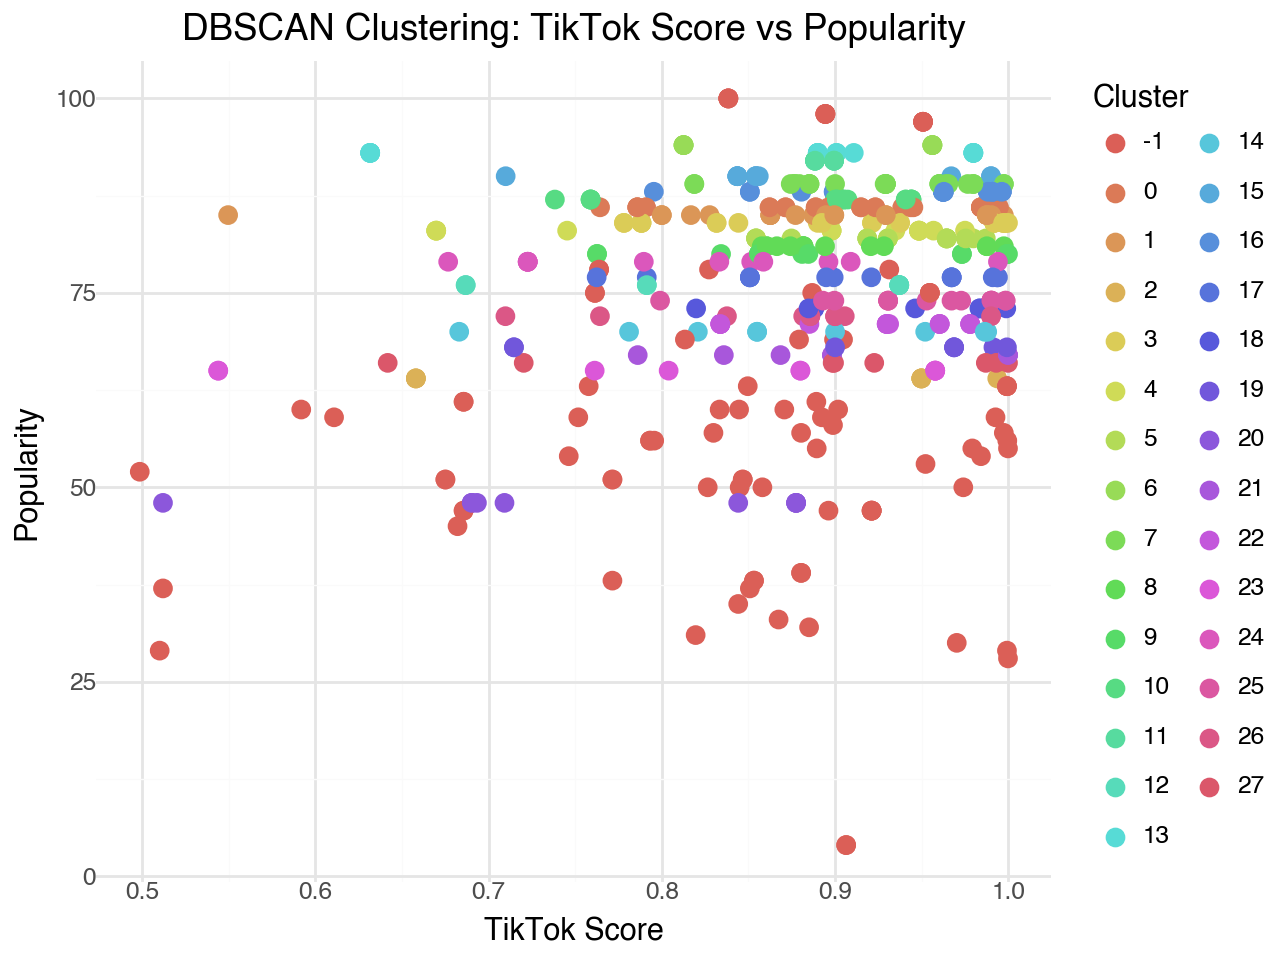

In [21]:
# Unscaled plot
dbscan = DBSCAN(eps=0.5, min_samples=8) 
data_df["Cluster_DBSCAN"] = dbscan.fit_predict(data_df[["TikTok_Score", "Popularity"]])

plot = (
    ggplot(data_df, aes(x="TikTok_Score", y="Popularity", color="factor(Cluster_DBSCAN)")) 
    + geom_point(size=3) # Scatter plot
    + labs(
        title="DBSCAN Clustering: TikTok Score vs Popularity",
        x="TikTok Score",
        y="Popularity",
        color="Cluster"
    )
    + theme_minimal()
)

display(plot)

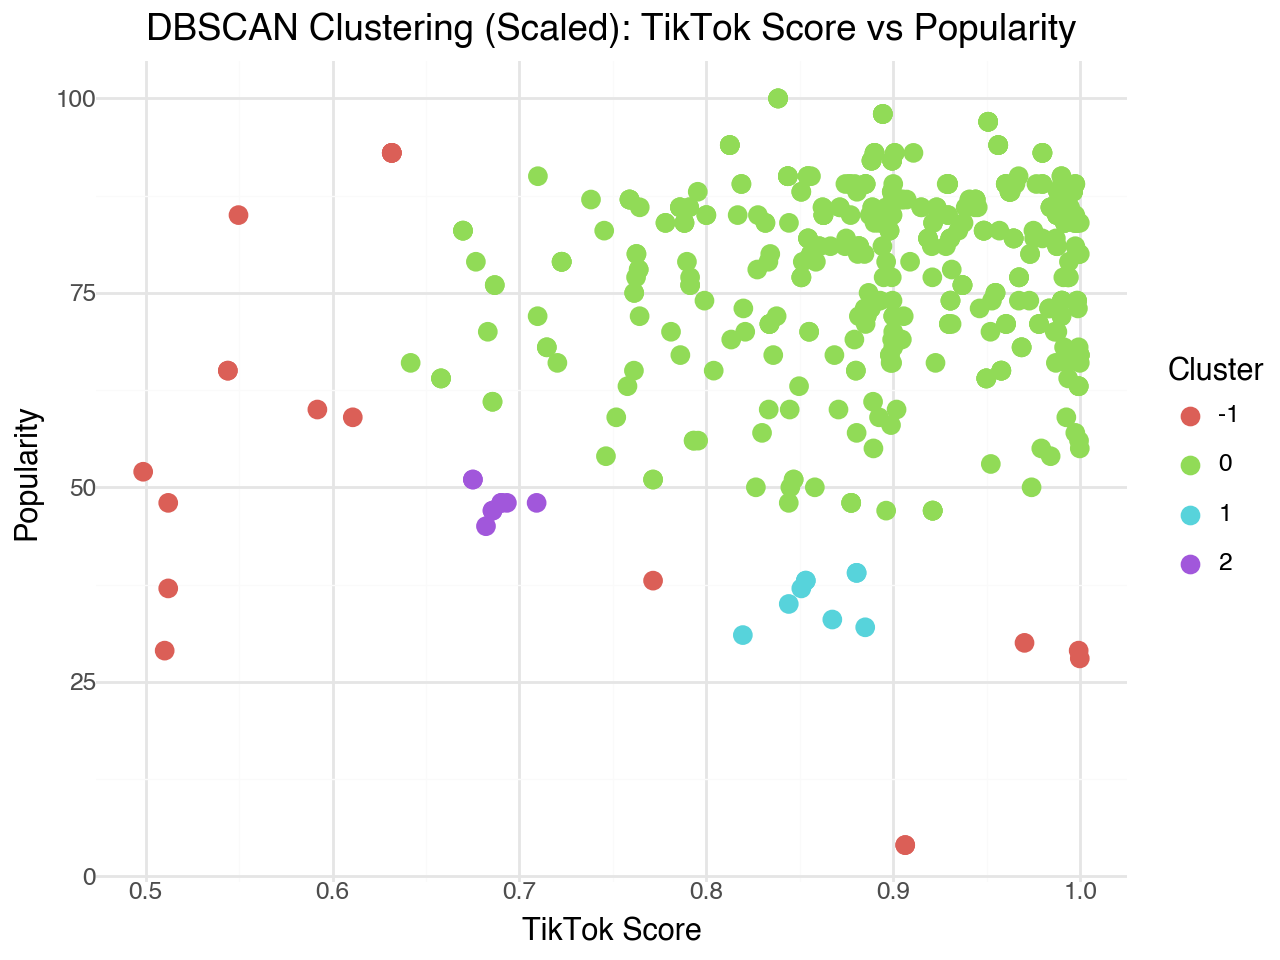

In [22]:
# Scaled plot
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_df[["TikTok_Score", "Popularity"]])

# Apply DBSCAN on scaled data
data_df["Cluster_DBSCAN_Scaled"] = dbscan.fit_predict(scaled_data)

scaled_plot = (
    ggplot(data_df, aes(x="TikTok_Score", y="Popularity", color="factor(Cluster_DBSCAN_Scaled)")) 
    + geom_point(size=3) # Scatter plot
    + labs(
        title="DBSCAN Clustering (Scaled): TikTok Score vs Popularity",
        x="TikTok Score",
        y="Popularity",
        color="Cluster"
    )
    + theme_minimal()
)

# Display the plot
display(scaled_plot)

#### **NOTE**: Impact of **Scaling**  

After the data has been scaled, it is interesting to note that while the axes scales and the scatter plots remain the same, the number of clustering groups has decreased from 9 to 3.  

**Explanation**:

This is likely due to the significant difference in **magnitude of scale** of `Popularity` and `TikTok_Score`. 

Before scaling, the `Popularity` feature likely dominated the clustering algorithm due to its larger range, causing DBSCAN to form smaller clusters based on this feature. When the data is scaled, both features are treated equally, causing DBSCAN to detect fewer, more coherent clusters based on relative densities rather than being influenced by one feature's larger magnitude.

In [23]:
# Count the number of points in each cluster
cluster_counts = data_df["Cluster_DBSCAN_Scaled"].value_counts()
print(cluster_counts)

Cluster_DBSCAN_Scaled
 0    448
-1     19
 1      9
 2      9
Name: count, dtype: int64


In [24]:
# Calculate the median values for each cluster
cluster_summary = data_df.groupby("Cluster_DBSCAN_Scaled")[[ "TikTok_Score", "Popularity", "Energy", "Danceability", "Mode", "Acousticness", "Tempo"]].median()
cluster_summary

,TikTok_Score,Popularity,Energy,Danceability,Mode,Acousticness,Tempo
Cluster_DBSCAN_Scaled,,,,,,,
-1,0.631700,52.0,0.247,0.461,1.0,0.612,139.208
0,0.899576,81.0,0.650,0.664,1.0,0.127,119.705
1,0.853200,37.0,0.634,0.630,0.0,0.098,138.003
2,0.685605,48.0,0.352,0.378,1.0,0.739,89.680


#### **ANALYSIS**

##### **Cluster 0**:
* **Size**: 
    * Largest
* **Characteristics**: 
    * Highest `TikTok_Score`
    * Highest `Popularity` (almost double the value of the second highest popularity)
    * Highest `Energy` and `Danceabiity`
    * Low `Acousticness`
* **Interpretation**:
    * Captures the majority of data
    * Represents mainstream, highly popular, largely "Tik-Tokified" tracks


##### **Cluster -1 (Noise)**:
* **Size**:
    * Small
* **Characteristics**:
    * Lowest `TikTok_Score`
    * Moderately high `Popularity`
    * Lowest `Energy` 
    * Moderately low `Danceability`
    * Very high `Acousticness` and `Tempo`
* **Interpretation**:
    * Outliers: fringe fast-paced acoustic tracks which have a niche audience, perhaps due to the lack of alignment with TikTok-style tracks (*although there might just be too much noise for a meaningful interpretation*)


##### **Cluster 1**:
* **Size**:
    * Small 
* **Characteristics**:
    * High `TikTok_Score`
    * Lowest `Popularity`
    * Similar `Energy`, `Danceability` and `Acousticness` to Cluster 0
    * Very high `Tempo`
    * Only cluster with median `Mode` as Minor key
* **Interpretation**:
    * Represents niche, fast-tempo tracks in Minor key that haven't gained mainstream traction
    * Contradicts the high TikTok score (*perhaps this is an indication that our TikTok_Score metric is incomplete as a high TikTok score should correlate to high Popularity in general due to the reach the track can gain from TikTok and how popular songs are used for TikTok*)


##### **Cluster 2**:
* **Size**:
    * Small
* **Characteristics**:
    * Low `TikTok_Score`
    * Moderately low `Popularity`
    * Highest `Acousticness` 
    * Smallest `Tempo`
    * Low `Energy` and `Danceability`
* **Interpretation**:
    * Represents slower acoustic tracks that appeal to a smaller audience and are not typical tracks used on TikTok 

## **05 Further Data Visualisation by playlist**

### **Merging Secondary DataFrame (`track_to_playlist_df`) to Main DataFrame (`data_df`)**

Given that `Viral50-<region>` and `Top50-<region>` are the two consistent types of playlists across regions, let us further analyse the tracks in them.

In [25]:
# Filter Top50 and Viral50 playlists
track_to_playlist_filtered_df = track_to_playlist_df[track_to_playlist_df["Playlist"].str.contains("Top50|Viral50")]

In [26]:
track_to_playlist_filtered_df

,Track_ID,Playlist
0,0nj9Bq5sHDiTxSHunhgkFb,Top50-USA
1,0aB0v4027ukVziUGwVGYpG,Top50-USA
2,2CGNAOSuO1MEFCbBRgUzjd,Top50-USA
3,5gOfC9UzZQzTyShqPMrpjT,Top50-USA
4,5S8VwnB4sLi6W0lYTWYylu,Top50-USA
...,...,...
545,63ZSKE6wZag6fV3YIfJc4d,Viral50-UK
546,6yozk84rHLypCWk50d5mTE,Viral50-UK
547,54eCdfu10x7x7uHJ5TY5KZ,Viral50-UK
548,2uvE4L5ZsYKpv8hbK4TIOt,Viral50-UK


In [27]:
# Merge data_df with track_to_playlist_filtered_df
data_playlist_df = (
    track_to_playlist_filtered_df
    .merge(data_df, on="Track_ID", how="left")
    .loc[lambda df: df.apply(lambda row: row["Region"] in row["Playlist"], axis=1)]
    .reset_index(drop=True)
    )

In [28]:
data_playlist_df

,Track_ID,Playlist,Track_Name,Popularity,Region,Energy,Tempo,Danceability,Mode,Acousticness,TikTok_Score,Cluster_DBSCAN,Cluster_DBSCAN_Scaled
0,0nj9Bq5sHDiTxSHunhgkFb,Top50-USA,squabble up,86,USA,0.672,103.921,0.874,1,0.021,0.984151,0,0
1,0aB0v4027ukVziUGwVGYpG,Top50-USA,tv off (feat. lefty gunplay),85,USA,0.529,100.036,0.855,0,0.084,0.862640,1,0
2,2CGNAOSuO1MEFCbBRgUzjd,Top50-USA,luther (with sza),64,USA,0.575,138.008,0.707,1,0.251,0.949800,2,0
3,5gOfC9UzZQzTyShqPMrpjT,Top50-USA,wacced out murals,84,USA,0.501,81.998,0.761,0,0.249,0.788269,3,0
4,5S8VwnB4sLi6W0lYTWYylu,Top50-USA,hey now (feat. dody6),83,USA,0.358,102.011,0.806,1,0.004,0.897970,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,63ZSKE6wZag6fV3YIfJc4d,Viral50-UK,This Is Who I Am - From “The Day of the Jackal”,57,UK,0.418,117.776,0.501,0,0.105,0.829800,-1,0
396,6yozk84rHLypCWk50d5mTE,Viral50-UK,Misleading,55,UK,0.809,127.031,0.792,1,0.104,0.979200,-1,0
397,54eCdfu10x7x7uHJ5TY5KZ,Viral50-UK,MAYBE.,70,UK,0.358,95.169,0.572,0,0.918,0.683078,14,0
398,2uvE4L5ZsYKpv8hbK4TIOt,Viral50-UK,MUTT,71,UK,0.455,179.787,0.572,1,0.216,0.929800,22,0


### **Viral vs Top Hit across Regions**
using a *Bar Plot* with a *Regression Line*

In [37]:
# Define regions
regions = ["Global", "UK", "USA", "Singapore"]

# Create a dropdown for region selection
dropdown = widgets.Dropdown(
    options=regions,
    value="Global",
    description="Region:"
)

# Interactive widget display
widgets.interactive(my_functions_03.update_plot_playlist, df=widgets.fixed(data_playlist_df), region=dropdown)

interactive(children=(Dropdown(description='Region:', options=('Global', 'UK', 'USA', 'Singapore'), value='Glo…

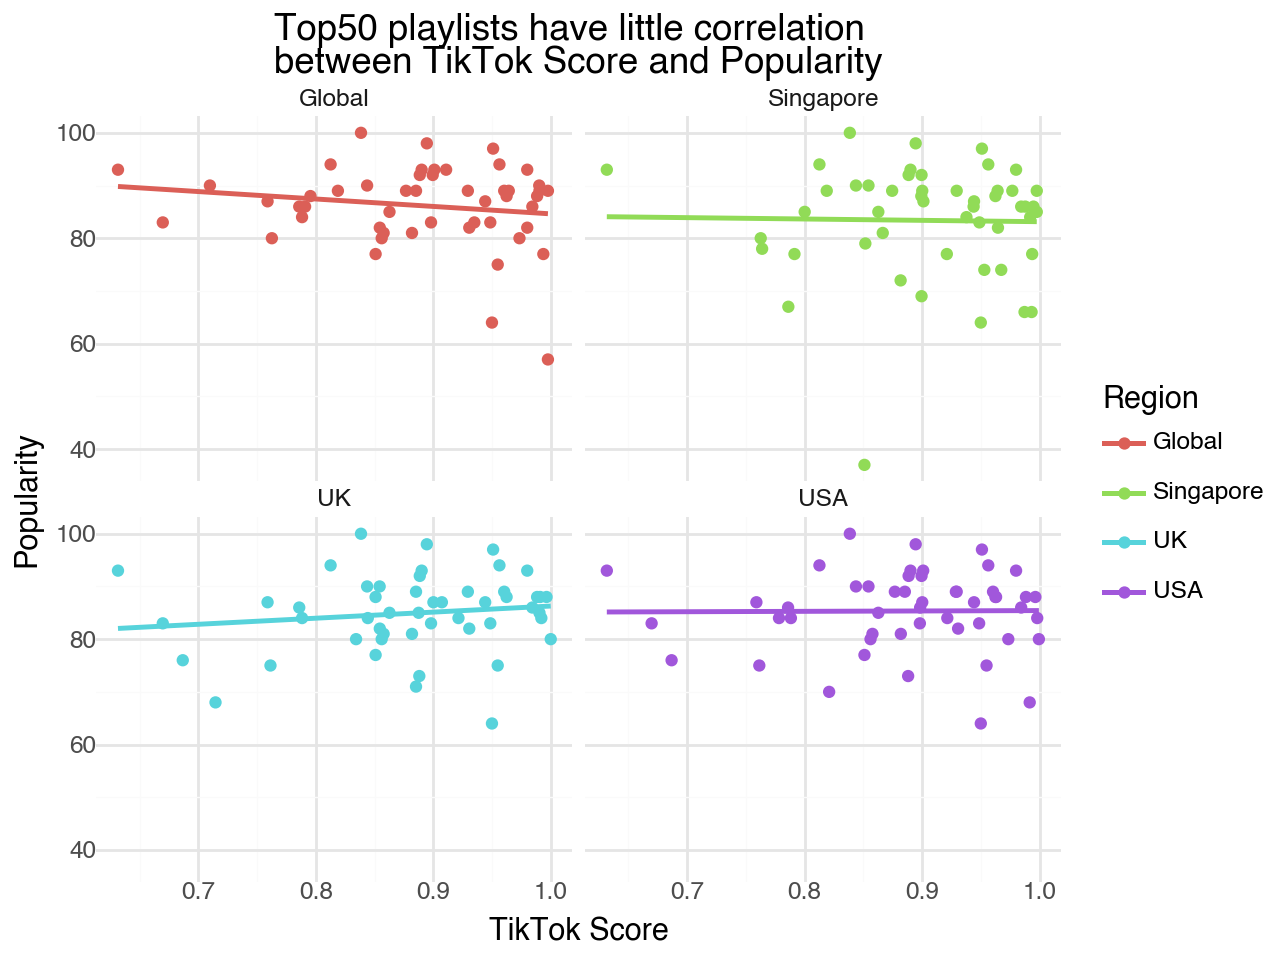

In [57]:
top50_df = data_playlist_df[data_playlist_df["Playlist"].str.contains("Top50")]

plot = (
    ggplot(top50_df, aes(x="TikTok_Score", y="Popularity", color="Region"))
    + geom_point()  # Scatter plot
    + geom_smooth(method="lm", se=False)  # Linear regression line
    + labs(
        title="Top50 playlists have little correlation \nbetween TikTok Score and Popularity",
        x="TikTok Score",
        y="Popularity"
    ) + theme_minimal()
    + facet_wrap("~Region")
    + theme(
        plot_title=element_text(hjust=0.5)
    )
)

display(plot)

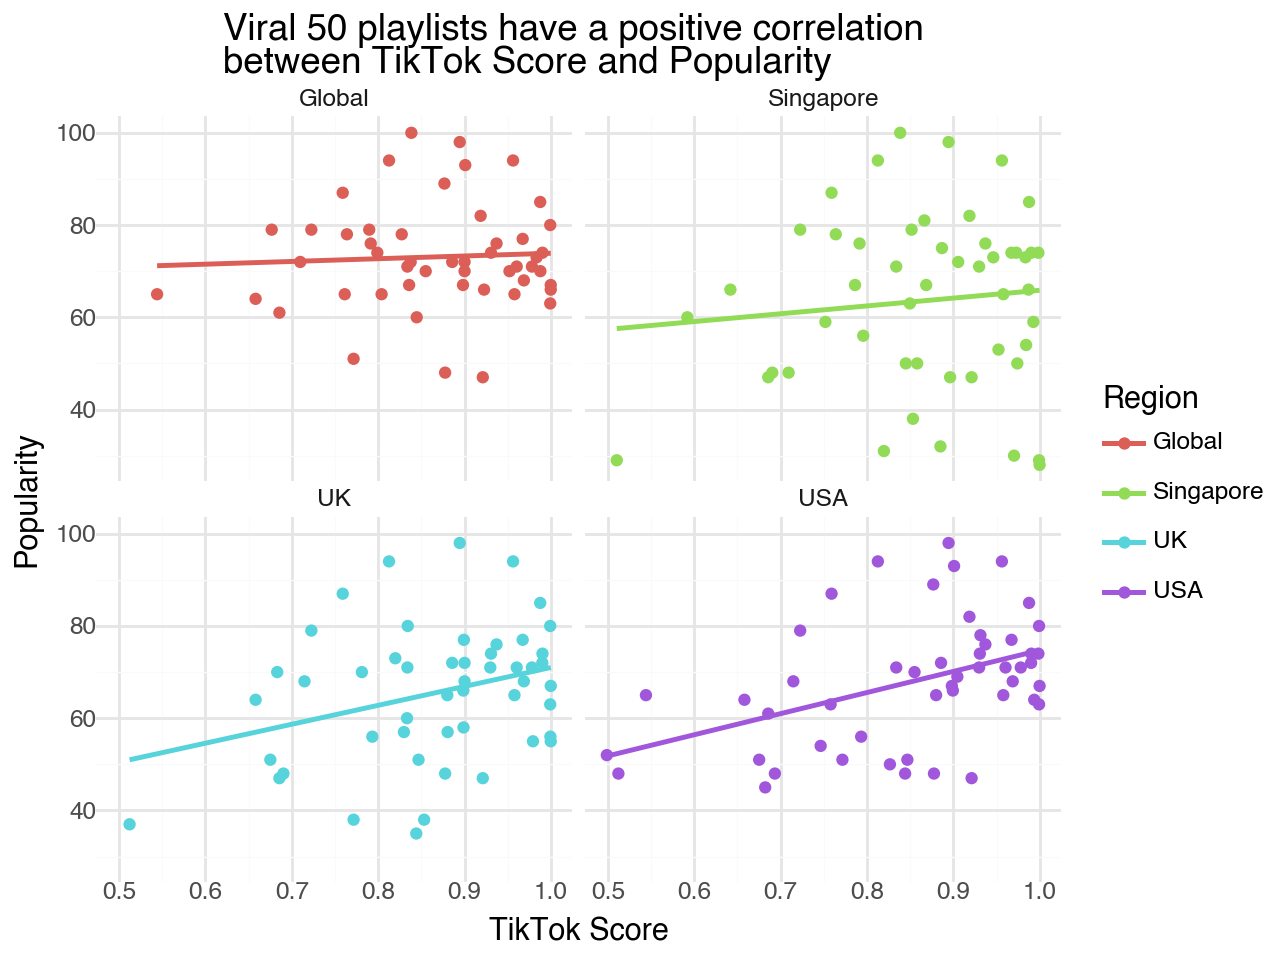

In [53]:
viral50_df = data_playlist_df[data_playlist_df["Playlist"].str.contains("Viral50")]

plot = (
    ggplot(viral50_df, aes(x="TikTok_Score", y="Popularity", color="Region"))
    + geom_point()  # Scatter plot
    + geom_smooth(method="lm", se=False)  # Linear regression line
    + labs(
        title="Viral 50 playlists have a positive correlation \nbetween TikTok Score and Popularity",
        x="TikTok Score",
        y="Popularity"
    ) + theme_minimal()
    + facet_wrap("~Region")
    + theme(
        plot_title=element_text(hjust=0.5)
    )
) 

display(plot)

#### **ANALYSIS**
* `Viral50` tracks always have significantly lower popularity than `Top50`tracks across TikTok scores. This can be analysed based on the nature of the playlists. Tracks on `Viral50` likely gain their position due to rapid increases in sharing and engagement rates, while tracks in `Top50` are typically curated based on sustained engagement, reflecting established popularity and mass appeal.

* `Top50` tracks across regions do not show much correlation between TikTok scores and popularity, indicating that other factors besides "TikTokiness" significantly influence popularity of Spotify tracks. 

* `Viral50-USA` and `Viral50-UK` showed the strongest positive correlation between TikTok score and popularity, followed by `Viral50-Singapore` and lastly `Viral50-Global`. This indicates that tracks chosen to be in `Viral50-USA` and `Viral50-UK` are closely aligned to the trend of higher TikTok scores having higher popularity. 


## **06 Conclusion**

#### **"TikTokiness" and popularity are weakly correlated**

Based on my analysis, there is a **weak positive correlation** between how closely aligned a track is to TikTok-like features and its popularity, as shown by our [scatter plot of popularity against TikTok scores](#tiktok-score-and-popularity) and that against [regions](#tiktok-score-vs-popularity-by-region). This is further reinforced by our [cluster analysis](#cluster-analysis), which showed the majority of data points clustered at the high TikTok score and high popularity corner of the plot. However, [further analysis by playlist](#viral-vs-top-hit-across-regions) showed that this trend varies in different playlists - Top50 playlists did not have such a correlation unlike Viral50. 


However, this conclusion suggests opportunities for further analysis to explore stronger correlations between "TikTokiness" and popularity. Our preliminary analysis, based on a limited dataset, has already indicated a weak correlation between these two factors. By integrating more data from Spotify and TikTok, perhaps more interesting trends can be identified.